In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2020-10-28 13:21:14--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M   119KB/s    in 42m 30s 

2020-10-28 14:03:45 (126 KB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [38]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import int_shape

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

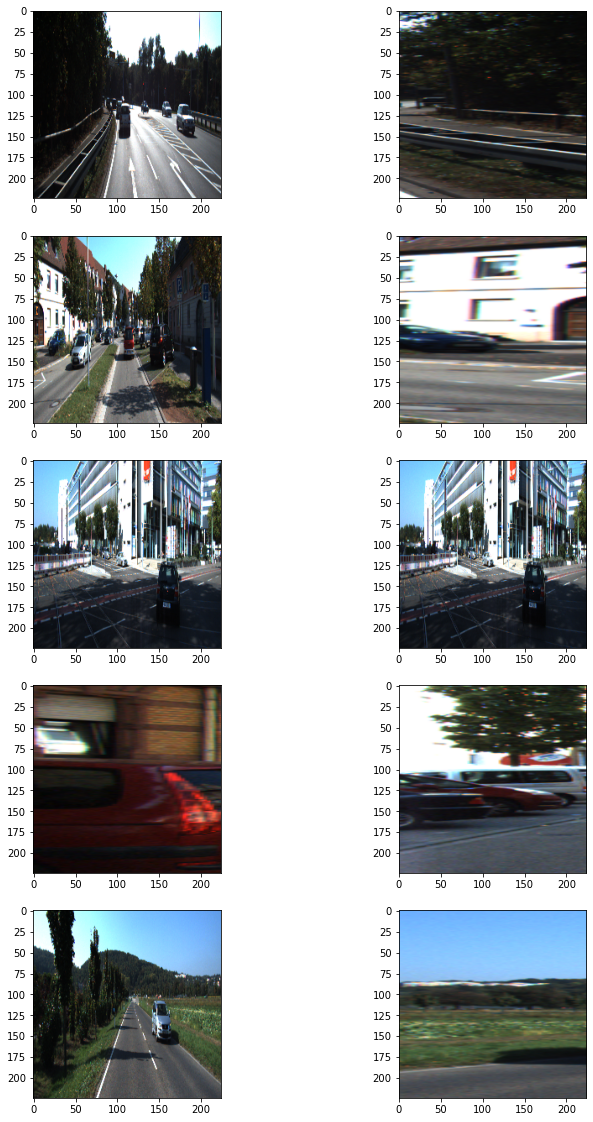

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [35]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [39]:
def Unet_model(input_shape=(224, 224, 3), filters= [64, 128, 256, 512, 1024], kernel=3):
    inputs = Input(input_shape)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    b1 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(b1)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    b2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(b2)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    b3 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(b3)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    b4 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(b4)
    x = Dropout(0.5)(x)
    x = Conv2D(filters[4], kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u1_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b4), int_shape(x))
    r1 = Cropping2D(cropping=(ch, cw), name='u1_resize')(b4)
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b3), int_shape(x))
    r2 = Cropping2D(cropping=(ch, cw), name='u2_resize')(b3)
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='valid', name='u3_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b2), int_shape(x))
    r3 = Cropping2D(cropping=(ch, cw), name='u3_resize')(b2)
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='valid', name='u4_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b1), int_shape(x))
    r4 = Cropping2D(cropping=(ch, cw ), name='u4_resize')(b1)
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [40]:
u_model = Unet_model()
u_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
b1_conv1 (Conv2D)               (None, 222, 222, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
b1_conv2 (Conv2D)               (None, 220, 220, 64) 36928       b1_conv1[0][0]                   
__________________________________________________________________________________________________
b2_pool (MaxPooling2D)          (None, 110, 110, 64) 0           b1_conv2[0][0]                   
____________________________________________________________________________________________

In [41]:
u_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
history = u_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
u_model.save(model_path)  #학습한 모델을 저장해 주세요.

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 43 steps, validate for 8 steps
Epoch 1/100
43/43 [==============================] - 6s 142ms/step - loss: 0.6563 - val_loss: 0.3565
Epoch 2/100
43/43 [==============================] - 4s 91ms/step - loss: 0.2924 - val_loss: 0.3070
Epoch 3/100
43/43 [==============================] - 4s 88ms/step - loss: 0.2809 - val_loss: 0.3070
Epoch 4/100
43/43 [==============================] - 4s 93ms/step - loss: 0.2732 - val_loss: 0.3070
Epoch 5/100
43/43 [==============================] - 4s 89ms/step - loss: 0.2864 - val_loss: 0.3069
Epoch 6/100
43/43 [==============================] - 4s 93ms/step - loss: 0.2816 - val_loss: 0.3068
Epoch 7/100
43/43 [==============================] - 4s 88ms/step - loss: 0.2984 - val_loss: 0.3068
Epoch 8/100
43/43 [==============================] - 4s 88ms/step - loss: 0.2876 - val_loss: 0.3067
Epoch 9/100
43/43 [==============================] - 4s 89ms/step - loss: 0.2819 - val_loss: 0.3067
Epoch 10

In [73]:
def Upp_model(input_shape=(224, 224, 3), filters= [0, 64, 128, 256, 512], kernel=3):
    inputs = Input(input_shape)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x0_0)
    
    x1_0 = MaxPooling2D(pool_size=(2,2), name='x1_0_pool')(inputs)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv1')(inputs)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv2')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    
    x2_0 = MaxPooling2D(pool_size=(2,2), name='x2_0_pool')(x1_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv1')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv2')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    
    x3_0 = MaxPooling2D(pool_size=(2,2), name='x3_0_pool')(x2_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv1')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv2')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    
    x4_0 = MaxPooling2D(pool_size=(2,2), name='x4_0_pool')(x3_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv1')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv2')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    
    u4_0 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u4_0_convTran')(x4_0)
    r3_0 = tf.image.resize(x3_0, (u4_0.shape[1], u4_0.shape[2]), name='x3_0_resize')
    x3_1 = concatenate([r3_0, u4_0], axis = 3, name='x3_1_merge')
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv1')(x3_1)
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv2')(x3_1)
    
    # 2-2로 감
    u3_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_0_convTran')(x3_0)
    r2_0 = tf.image.resize(x2_0, (u3_0.shape[1], u3_0.shape[2]), name='a_r2_0_resize')
    x2_1 = concatenate([r2_0,u3_0], axis = 3, name='x2_1_merge')
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv1')(x2_1)
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv2')(x2_1)
    
    # origin
    u3_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_1_convTran')(x3_1)
    r2_0 = tf.image.resize(x2_0, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_0_resize')
    r2_1 = tf.image.resize(x2_1, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_1_resize')
    x2_2 = concatenate([r2_0,r2_1, u3_1], axis = 3, name='x2_2_merge')
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv1')(x2_2)
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv2')(x2_2)
    
    # 1-3로 감
    u2_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_0_convTran')(x2_0)
    r1_0 = tf.image.resize(x1_0, (u2_0.shape[1], u2_0.shape[2]), name='a_r1_0_resize')
    x1_1 = concatenate([r1_0,u2_0], axis = 3, name='x1_1_merge')
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv1')(x1_1)
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv2')(x1_1)
    
    # 1-3로 감
    u2_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_1_convTran')(x2_1)
    r1_0 = tf.image.resize(x1_0, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_1_resize')
    x1_2 = concatenate([r1_0, r1_1, u2_1], axis = 3, name='x1_2_merge')
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv1')(x1_2)
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv2')(x1_2)
    
    # origin
    u2_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_2_convTran')(x2_2)
    r1_0 = tf.image.resize(x1_0, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_1_resize')
    r1_2 = tf.image.resize(x1_2, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_2_resize')
    x1_3 = concatenate([r1_0, r1_1, r1_2, u2_2], axis = 3, name='x1_3_merge')
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv1')(x1_3)
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv2')(x1_3)
    x1_3 = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='x1_3_conv3')(x1_3)
    x1_3 = Conv2D(1, 1, activation='sigmoid')(x1_3)
    output = tf.image.resize(x1_3, (inputs.shape[1], inputs.shape[2]), name='output')
    model = Model(inputs = inputs, outputs = output)
    return model

In [74]:
upp_model = Upp_model()
upp_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
x1_0_conv1 (Conv2D)             (None, 222, 222, 64) 1792        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 222, 222, 64) 256         x1_0_conv1[0][0]                 
__________________________________________________________________________________________________
x1_0_conv2 (Conv2D)             (None, 220, 220, 64) 36928       batch_normalization_94[0][0]     
___________________________________________________________________________________________

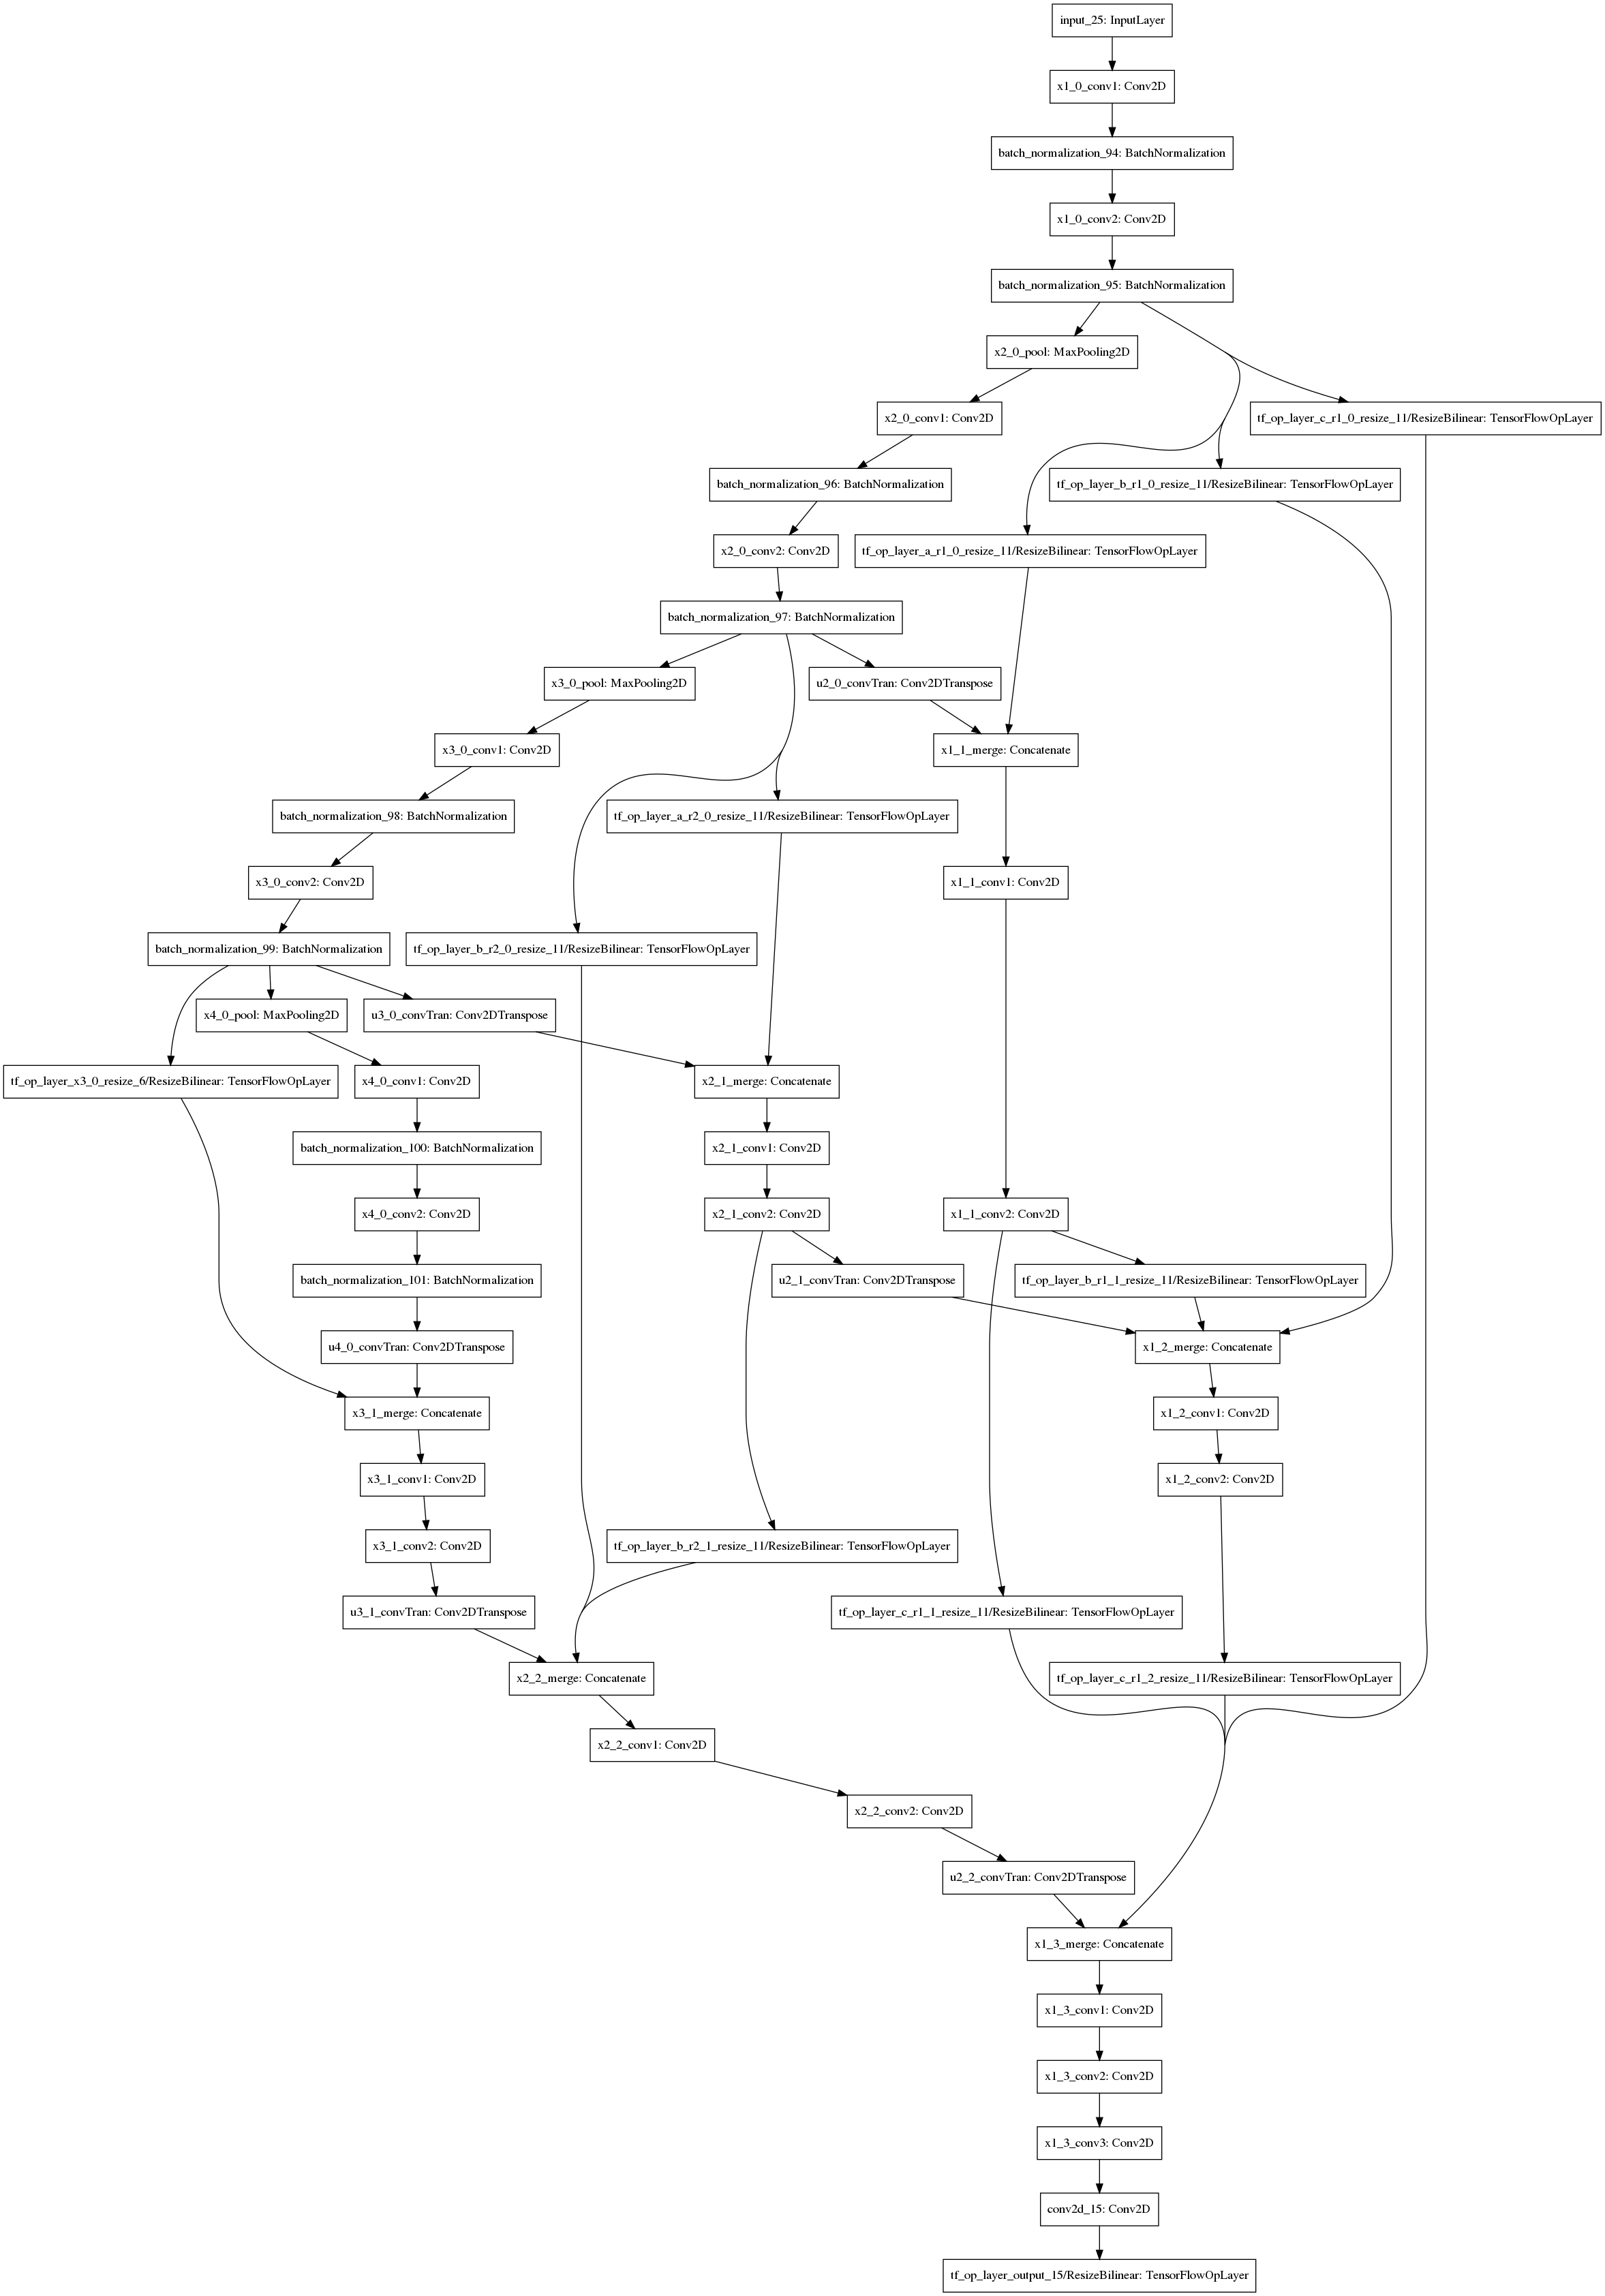

In [75]:
tf.keras.utils.plot_model(upp_model, to_file='./upp_model.png')

In [76]:
upp_model = Upp_model()
upp_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
upp_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_uppnet.h5'
upp_model.save(model_path)  #학습한 모델을 저장해 주세요.

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 43 steps, validate for 8 steps
Epoch 1/100
43/43 [==============================] - 12s 269ms/step - loss: 0.1522 - val_loss: 0.2017
Epoch 2/100
43/43 [==============================] - 10s 239ms/step - loss: 0.0985 - val_loss: 0.1669
Epoch 3/100
43/43 [==============================] - 10s 231ms/step - loss: 0.0815 - val_loss: 0.1515
Epoch 4/100
43/43 [==============================] - 10s 232ms/step - loss: 0.0654 - val_loss: 0.1680
Epoch 5/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0776 - val_loss: 0.1302
Epoch 6/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0649 - val_loss: 0.1126
Epoch 7/100
43/43 [==============================] - 10s 233ms/step - loss: 0.0668 - val_loss: 0.2081
Epoch 8/100
43/43 [==============================] - 10s 234ms/step - loss: 0.0566 - val_loss: 0.1445
Epoch 9/100
43/43 [==============================] - 10s 234ms/step - loss: 0.0665 - val_loss

In [ ]:
# model_path = dir_path + '/seg_model_unet.h5'
# model = tf.keras.models.load_model(model_path)

In [12]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [46]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()  
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

## Summary

### UNet에 대한 실험

#### channel = [64, 128, 256, 512]

In [26]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     u_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.871469


0.8714688190055585

모델의 총 파라미터 수는 7,784,005개였습니다. 기본 모델은 5개의 블럭으로 구성되어 있지만, 마지막 channel 1024를 빼고 만들었습니다.  
모델을 돌려본 결과 val_loss: 0.0548이 나왔고 IoU는  0.87146이 나왔습니다. 

#### channel = [64, 128, 256, 512, 1024], Upsampling 전 dropout 추가, 

In [45]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     u_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.043466


0.043466337583984646

모델의 총 파라미터 수는 21,594,629개였습니다.  
5개의 블럭으로 구성되어있으며 마지막 중간단 (channel=1024)에서 conv을 하나빼고 padding=same으로 했습니다.  
모델을 돌려본 결과 val_loss: 0.2952 이 나왔고 IoU는 이상하게도 0.0이 나왔습니다.  
아마도 도로 영역을 잘 인식하지 못하는 것 같습니다.

## U++ Net에 대한 실험

#### Dropout 제거 && channel=2 Conv layer 미사용

In [16]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.865342


0.8653418245990946

Dropout 제거하고 channel=2 Conv layer 미사용했더니, 기존의 UNet 보다 성능이 안좋았습니다. 

#### Dropout=0.5 추가 && channel=2 Conv layer 미사용

In [30]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

IoU : 0.863558


0.8635578583765112

Dropout=0.5 추가만하고 channel=2 Conv layer 여전히 미사용한 결과 앞선 실험과 크게 차이가 없었습니다.

#### Dropout=0.5 추가 && channel=2 Conv layer 사용

In [47]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.889456


0.8894564305862621

channel=2 Conv layer를 사용하는 것만으로 상당히 좋은 성능을 보였습니다.  
마지막 chanel을 2개로 만드는 이유는 foreground와 background를 구별하기 위함입니다.  
이러한 역할을 빼면 더 성능이 안좋다는 사실을 실험을 통해 확인했습니다

####  Contracting path에서 Conv 마다 BatchNorm 추가

In [85]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.896350


0.8963499378245922

BatchNormalization을 추가했더니 IoU가 0.896350로 더욱 좋아졌습니다.  
그리고 기존의 Unet 보다는 U++Net이 성능이 더 좋아보였습니다. 

#### 최종 결과 사진

![](data/img/final_result.png)